Los problemas de clasificacion corresponden a un ejemplo de aprendisaje supervizado, donde el vector objetivo responde a un atributo 

Existen muchos fenomenos cuya primera aproximacion e smediante la binarizacion, ¿Existe o no existe una condicion?

Esta aproximacion toma forma en un ensayo de bernoulli.

La binarizacion corresponde a por ejemplo si van a comprar un cierto producto o no, si va votar por cierto candidato o no, hay un excetera de ejemplos y todos corresponden a un problema de calsificacion binario donde se observa la precencia o ausencia de un atributo especifico .

In [1]:
# importaciones analicis exploratorio y muestreo de datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# seaborn
import seaborn as sns
# scipy stats para simular
import scipy.stats as stats
# statsmodels para modelación
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")
import lec6_graphs as gfx
plt.style.use('seaborn') # Gráficos estilo seaborn
# plt.rcParams["figure.figsize"] = (6, 3) # Tamaño gráficos
# plt.rcParams["figure.dpi"] = 200 # resolución gráficos
# Regrecion Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Matriz de confusion y metricas de desempeño
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# ingresamos la base de datos
df = pd.read_csv('datasets/wells.csv')
# La base de datos incluye una columna de índice. Eliminemosla para evitar futuros conflictos
df = df.drop("index", axis = 1)
df.head()

,y,dist100,arsenic,educ4,assoc
0,1,0.16826,2.36,0.0,0
1,1,0.47322,0.71,0.0,0
2,0,0.20967,2.07,2.5,0
3,1,0.21486,1.15,3.0,0
4,1,0.40874,1.10,3.5,1


In [3]:
df.shape

(3020, 5)

In [4]:
df.columns

Index(['y', 'dist100', 'arsenic', 'educ4', 'assoc'], dtype='object')

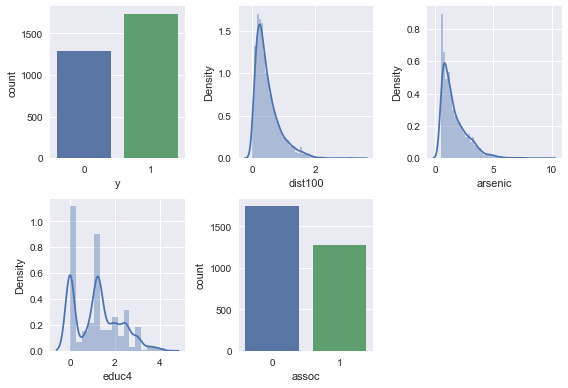

In [5]:
for index, value in enumerate(df):
    plt.subplot(2, 3, index + 1)
    if len(df[value].value_counts()) > 2:
        sns.distplot(df[value])
    else:
        sns.countplot(df[value])
    plt.tight_layout()
    

<AxesSubplot:>

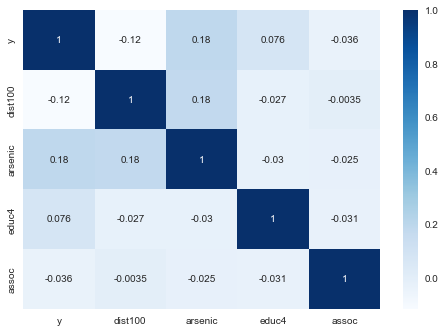

In [6]:
sns.heatmap(df.corr(), cmap = 'Blues', annot = True)

Primera aproximación: utilizar una regrecion lineal asumiendo que nuestra variable dependiente mide la probabilidad del suceso.

Este preoceso se conoce como modelo de probabilidad lineal.

$$Y_i = \beta_0 + \beta_1 \times dist100 + \varepsilon_i$$

La interpretacion de los coeficientes se hace consideracion a la probabilidad de ocurrencia del suceso.

In [7]:
m1_ols = smf.ols('y ~ dist100', df).fit()

In [8]:
def conciense_summary(mod, print_fit = True):
    '''
    Esta funcion genera un resumen abreviado de los principales estadisticos de un modelo.
    Parametros de ingreso: Modelo
    Parametros de salida: Un print
    '''
    fit = pd.DataFrame({'Statistics':mod.summary2().tables[0][0][2:], 
                        'Value':mod.summary2().tables[0][3][2:]})
    estimates = pd.DataFrame(mod.summary2().tables[1].loc[:, 'Coef.':'Std.Err.'])

    if print_fit is True:
        print(f'''
Goodness of Fit statistics 
{fit}''')

    print(f'''
Point estimates
{estimates}''')

In [9]:
conciense_summary(m1_ols)


Goodness of Fit statistics 
          Statistics      Value
2              Date:  4288.4686
3  No. Observations:    -2136.2
4          Df Model:      42.57
5      Df Residuals:   7.95e-11
6         R-squared:    0.24111

Point estimates
              Coef.  Std.Err.
Intercept  0.648407  0.014347
dist100   -0.151539  0.023225


Para obtener el puntaje Z vamos a dividir el coeficiente del intercepto por el error estandart del intercepto.
0.648407 / 0.014347

45.19460514393253

In [10]:
0.648407/0.014347

45.19460514393253

In [11]:
-0.151539 / 0.023225

-6.5248223896663085

Es superio a los puntos criticos por lo que hay evidencia para rechar la hipotecis nula
Ambos estadisticos son una buena aproximacion del modelo

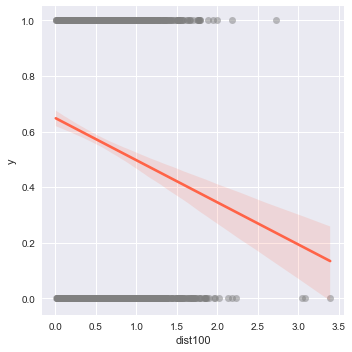

In [12]:
sns.lmplot('dist100', 'y', df, line_kws = {'color':'tomato'}, 
                            scatter_kws = {'color':'grey', 'alpha': .5})

La estimacion de los coeficientes en la regrecion logistica se realiza mediante el metodo de maxima verosimilitud
$$  log \left(\dfrac{Pr(y)}{1 - Pr(y)} \right)= \beta_0 + \beta_1 \times dist100 + \varepsilon_i$$

In [13]:
m1_logit = smf.logit('y ~ dist100', df).fit()
conciense_summary(m1_logit)

Optimization terminated successfully.
         Current function value: 0.674874
         Iterations 4

Goodness of Fit statistics 
          Statistics       Value
2              Date:   4092.2639
3  No. Observations:     -2038.1
4          Df Model:     -2059.0
5      Df Residuals:  9.7978e-11
6         Converged:      1.0000
7    No. Iterations:            

Point estimates
              Coef.  Std.Err.
Intercept  0.605959  0.060310
dist100   -0.621882  0.097426


>El objetivo es traducir de log-odds a una declaracion probabilistica. Asi generamos una explicacion intituiva sobre el efecto de una variable en la probabilidad de ocurrencia
>
>$$ logit^{-1} (x)= \dfrac{exp(x)}{1 + exp(-x)} $$
>$$	\Downarrow $$
>$$ Pr(Cambio\ de\ pozo = 1 |X) = log \dfrac{exp(\beta_0 + \beta_1)}{1 + exp(\beta_0 + \beta_1)} $$

In [14]:
dist100_mean = df['dist100'].mean()
estimate_y = m1_logit.params['Intercept'] + (m1_logit.params['dist100'] + dist100_mean)
print(estimate_y)

0.4673960540623984


In [15]:
def invlogit(x):
    return 1 / (1 + np.exp(-x))
print(invlogit(estimate_y))


0.6147672524277406


In [16]:
dist100_mean

0.4833186257042435

In [17]:
pr_dist_100 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 1))
pr_dist_200 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 2))
pr_dist_300 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 3))
pr_dist_400 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 4))

In [18]:
pr_dist_100, pr_dist_200, pr_dist_300, pr_dist_400

(0.4960194411878717,
 0.34574300299201427,
 0.22102787555555548,
 0.13220883169891445)

In [19]:
print(f'La probabilidad de cambiar entre 100 y 200 es de {round(pr_dist_100 - pr_dist_200, 3)}')

La probabilidad de cambiar entre 100 y 200 es de 0.15


In [20]:
print(f'La probabilidad de cambiar entre 200 y 300 es de {round(pr_dist_200 - pr_dist_300, 3)}')

La probabilidad de cambiar entre 200 y 300 es de 0.125


In [21]:
print(f'La probabilidad de cambiar entre 300 y 400 es de {round(pr_dist_300 - pr_dist_400, 3)}')

La probabilidad de cambiar entre 300 y 400 es de 0.089


In [22]:
decision_boundary = - m1_logit.params['Intercept'] / m1_logit.params['dist100']
decision_boundary

0.97439615007053

(0.0, 0.8)

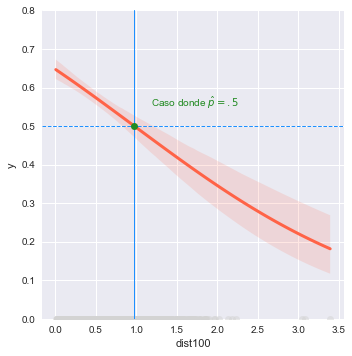

In [23]:
from turtle import color


sns.lmplot('dist100', 'y', df, logistic = True, line_kws={'color':'tomato', 'lw':3},
                                            scatter_kws={'color':'lightgrey', 'alpha':.5})
                                            
plt.axvline(decision_boundary, lw = 1, color = 'dodgerblue')
plt.axhline(.5, linestyle = '--', color = 'dodgerblue', lw = 1)
plt.text(decision_boundary + .2, .5 + .05, r'Caso donde $\hat{p}=.5$', color = 'forestgreen')
plt.plot(decision_boundary, .5, 'o', color = 'forestgreen')
plt.ylim(0.0, 0.8)

In [24]:
print('OLS - LPM')
conciense_summary(m1_ols, print_fit = False)

print('Logit')
conciense_summary(m1_logit, print_fit = False)

OLS - LPM

Point estimates
              Coef.  Std.Err.
Intercept  0.648407  0.014347
dist100   -0.151539  0.023225
Logit

Point estimates
              Coef.  Std.Err.
Intercept  0.605959  0.060310
dist100   -0.621882  0.097426


In [25]:
-0.62 / 4

-0.155

Clasificacion desde el Machine Learning

Dividimos la muestra con train_test_split

In [26]:
x_train_pre, x_test_pre, y_train, y_test = train_test_split(df.loc[:, 'dist100':'assoc'], 
                                                        df['y'], test_size = .33, 
                                                        random_state = 15820)

Transformamos los conjuntos de entrenamiento y test la con transformacion entrenada sobre el conjunto de entrenamiento

In [27]:
scaler = StandardScaler().fit(x_train_pre)
x_train = scaler.transform(x_train_pre)
x_test = scaler.transform(x_test_pre)

Luego de tener nuestras matrices estandarizadas, instanciamos a LogisticRegression() y la vamos a entrenar con nuestras matrices de entrenamiento

In [28]:
default_model = LogisticRegression().fit(x_train, y_train)

In [29]:
default_model.coef_

array([[-0.28398626,  0.53436482,  0.18001498, -0.03678595]])

#### Metricas de desempeño.

Ahora que tenemos nuestro modelo entrenado, podemos pedirle que aga algunas predicciones sobre un conjunto de datos. Vamos hacer que aga todas las predicciones para el conjunto de test

In [30]:
yhat = default_model.predict(x_test)
yhat[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [31]:
yhat_pr = default_model.predict_proba(x_test)
yhat_pr[:20]

array([[0.23213126, 0.76786874],
       [0.36406036, 0.63593964],
       [0.45295198, 0.54704802],
       [0.4538275 , 0.5461725 ],
       [0.22100255, 0.77899745],
       [0.49336206, 0.50663794],
       [0.36687675, 0.63312325],
       [0.14194144, 0.85805856],
       [0.47597782, 0.52402218],
       [0.48324471, 0.51675529],
       [0.43320904, 0.56679096],
       [0.58241544, 0.41758456],
       [0.54819581, 0.45180419],
       [0.35159417, 0.64840583],
       [0.36450069, 0.63549931],
       [0.48285301, 0.51714699],
       [0.27478505, 0.72521495],
       [0.45117916, 0.54882084],
       [0.36574692, 0.63425308],
       [0.43571371, 0.56428629]])

### Matriz de confusion.

Es cruce de informacion predicha y etiquetas reales en la muetra de validacion.

Permite observar la cantidad de observaciones predichas de forma correcta

In [32]:
m1_confusion = confusion_matrix(y_test, yhat)
m1_confusion

array([[177, 261],
       [112, 447]], dtype=int64)

In [33]:
m1_acc = accuracy_score(y_test, yhat)
m1_acc

0.6258776328986961

In [34]:
m1_acc - .5

0.12587763289869613

### Accuracy, Precision, Recall

Exactitud: Casos correctamente predichos del total de observaciones.

$$ Exactitud = \dfrac{VP + VN}{VP + VN + FP + FN} $$

Precision: Etiquetas correctas en las positivas.

$$ Presicion = \dfrac{VP}{VP + FP} $$

Recall: Verdaderos positivos entre los predichos del modelo.

$$ Presicion = \dfrac{VP}{VP + FN} $$

VN = Verdadero Negativo

VP = Verdadero Negativo

FP = Faslso Positivo

FN = Falso Negativo


In [35]:
m1_prec = precision_score(y_test, yhat)
m1_prec

0.6313559322033898

In [36]:
m1_recall = recall_score(y_test, yhat)
m1_recall

0.7996422182468694

In [37]:
m1_fscore = f1_score(y_test, yhat)
m1_fscore

0.7056037884767167

In [38]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.61      0.40      0.49       438
           1       0.63      0.80      0.71       559

    accuracy                           0.63       997
   macro avg       0.62      0.60      0.60       997
weighted avg       0.62      0.63      0.61       997



### Curva ROC
Permite evaluar el rango de errores de un modelo

Evalua la relacion entre falsos positivos y verdaderos positivos

* En el eje X va la tasa de Falsos Positivos(Falsas alarmas)
* En el eje Y va la tasa de Verdaderos Positivos

In [39]:
y_test

743     1
2159    0
1099    0
1430    1
1531    1
       ..
1247    1
775     0
2080    0
462     1
572     0
Name: y, Length: 997, dtype: int64

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'dist100':'assoc'], 
                                                        df['y'], test_size = .33, 
                                                        random_state = 15820)

In [41]:
from sklearn.metrics import roc_curve
yhay_pr_roc = default_model.predict_proba(X_test)[:, 1]
false_positive, true_positive, threshol = roc_curve(y_test, yhay_pr_roc)

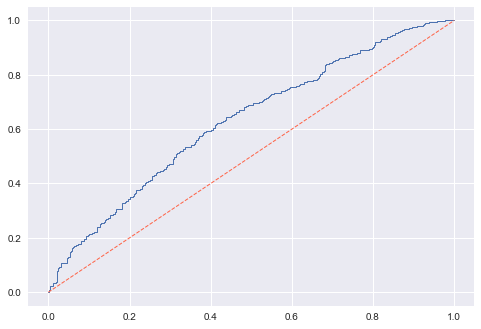

In [42]:
plt.plot(false_positive, true_positive, lw = 1)
plt.plot([0, 1], linestyle = '--', lw = 1, color = 'tomato')

In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, yhat)


0.6018759036439826

### Validacion Cruzada

* Situacion comun: no existen suficientes observaciones como para generar un estadistico de prueba robusta.
* Solucion: iterar de forma sucesiva simulando el entrenamiento del modelo en multiples muestras.
* Por cada muetsra se estima una metrica de desempeño.

### K-Fold Cross Validation

$$ E= \dfrac{1}{10} \sum_{i=1}^{10} E_i $$

In [44]:
from sklearn.model_selection import cross_val_score

m1_cv = cross_val_score(LogisticRegression(), X = df.loc[:, 'dist100':'assoc'], y = df['y'], cv = 3, scoring = 'f1')
m1_cv

array([0.70499244, 0.6888361 , 0.7006079 ])

In [45]:
np.mean(m1_cv)

0.6981454809840354

In [46]:
np.std(m1_cv)

0.006821749533435546

### Leav One Out Cross Validation

* Version extrema de K-Fold Cros Validation.
* Generamos tantos modelos con (n-1) obseervaciones como observaciones existen en una muestra

In [47]:
from sklearn.model_selection import LeaveOneOut
m1_cv_loo = cross_val_score(LogisticRegression(), X = df.loc[:, 'dist100':'assoc'], y = df['y'], cv = LeaveOneOut(), scoring = 'accuracy')

In [48]:
np.mean(m1_cv_loo)

0.6142384105960265

In [49]:
np.std(m1_cv_loo)

0.4867746763590867

Experimento: Evaluacion de la complejidad del modelo condicional a terminos polinomiales.

* Objetivo: Desarrollar una serie de modelos aumentando las interacciones entre variables y evaluar cual es el mejor modelo.
* Metodo: Evaluar las metricas F1, Accuracy, Precision y Recall en tres grados polinomiales (1, 2 y 3). Para cada metrica:
  * Calcular los puntajes de validacion cruzada con k = 10 para cada modelo candidato.
  * Generar un objeto DataFrame, graficamos el diagrama de cajas.
  * Finiquitamos con detalles esteticos de presentacion.

#### Generar las matrices estandarizadas

In [50]:
std_matrix = StandardScaler().fit_transform(df.loc[:, 'dist100':'assoc'])

In [51]:
from sklearn.preprocessing import PolynomialFeatures

df_int_2 = PolynomialFeatures(degree = 2, interaction_only=True, include_bias=False).fit_transform(std_matrix)
df_int_3 = PolynomialFeatures(degree = 3, interaction_only=True, include_bias=False).fit_transform(std_matrix)

In [52]:
df.shape

(3020, 5)

In [53]:
df_int_2.shape

(3020, 10)

In [54]:
df_int_3.shape

(3020, 14)

#### Definir las metricas

In [55]:
eval_metric = ['f1', 'precision', 'recall', 'accuracy']

### Iniciar el loop

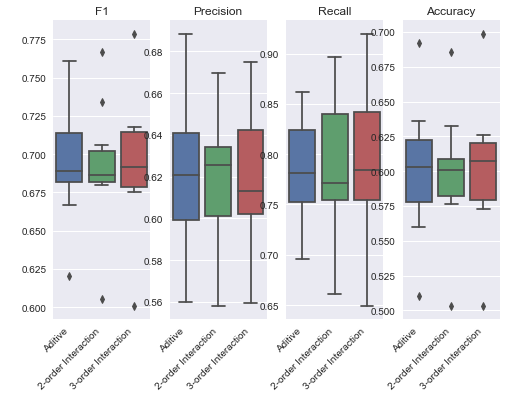

In [64]:
for index, value in enumerate(eval_metric):
        tmp_1 = cross_val_score(LogisticRegression(), df.loc[:, 'dist100':'assoc'], df['y'], cv = 10, scoring = value)
        tmp_2 = cross_val_score(LogisticRegression(), df_int_2, df['y'], cv = 10, scoring = value)
        tmp_3 = cross_val_score(LogisticRegression(), df_int_3, df['y'], cv = 10, scoring = value)
        tmp = pd.DataFrame({'Aditive':tmp_1, '2-order Interaction':tmp_2, '3-order Interaction':tmp_3}).unstack().reset_index()
        tmp.rename(columns={'level_0':'order', 'level_1':'num', '0':'score'}, inplace = True)

        plt.subplot(1, 4, index + 1)
        sns.boxplot(tmp.iloc[:, 0], tmp.iloc[:, 2])
        plt.title(value.capitalize())
        plt.ylabel(' ')
        plt.xlabel(' ')
        plt.xticks(rotation = 45, ha = 'right')

In [57]:
tmp

,order,num,0
0,Aditive,0,0.599338
1,Aditive,1,0.605960
2,Aditive,2,0.592715
3,Aditive,3,0.612583
4,Aditive,4,0.509934
5,Aditive,5,0.625828
6,Aditive,6,0.692053
7,Aditive,7,0.635762
8,Aditive,8,0.572848
9,Aditive,9,0.559603
